In [1]:
date = "20250519"

In [2]:
import pandas as pd
import numpy as np
from pandas import ExcelWriter
import gc

from sklearn.preprocessing import LabelEncoder




from sklearn.model_selection import train_test_split,KFold

from sklearn.metrics import confusion_matrix,f1_score,classification_report,accuracy_score
from sklearn.metrics import roc_auc_score

from scipy.stats import norm
import matplotlib.pyplot as plt
# import seaborn as sns
import time
import os
import openpyxl

import joblib
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout,Flatten,BatchNormalization
from tensorflow.keras.layers import Conv1D,Input
from tensorflow.keras.layers import MaxPooling1D,UpSampling1D,Lambda,Reshape
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Model


from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU

# from tensorflow.keras.losses import mse
from sklearn.ensemble import RandomForestClassifier

from collections import Counter
from imblearn.over_sampling import SMOTE
# from sklearn.utils import class_weight

# for now()
import datetime
# for timezone()
import pytz
# using now() to get current time
current_time = datetime.datetime.now(pytz.timezone('America/New_York'))
# printing current time in india
print("The current time is :", current_time)

pd.options.mode.chained_assignment = None

np.seterr(divide='ignore', invalid='ignore')

The current time is : 2025-05-19 13:48:12.221963-04:00


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# _celline = ["A549","NCI.H460","SK.N.SH","HT1080"]
_celline = ["A549"]
threshold = "class_0"

K = 6
max_miss = 1
encoding_dim = 512

# # input path
path_input = "../data/mer%s/"%(K)
# output path
path_output = "../results/with_ae/SMOTE/mer%s_%s/"%(K,date)

path_models = path_output+"models/"
ae_path = path_output + "ae_models/"

os.makedirs(path_output, exist_ok=True)
os.makedirs(path_models,exist_ok=True)
os.makedirs(ae_path, exist_ok=True)

CV = 5
max_len = 5000
segment = [(200,5000)]


_model_type = ["1DCNN","RF","MLP"]
ae_type = ["AE_MLP"]

encoding = "rawcounts"

# <font color=blue> Load data</font>
##  <font color=blue> load cell_line, kmer counts table, generate two class training set, 0 as threshold. </font>

In [4]:
def get_class(dff):

    for i in range(len(dff)):
        if dff.loc[i,Celline] >= 0:
            dff.loc[i,"Class"] = 1
        else:
            dff.loc[i,"Class"] = 0
#     print(">= 0 :{}, < 0 :{}".format(len(dff[dff[Celline]>=0]),len(dff[dff[Celline]<0])))
    return dff


def processdata(dff):
    x_train = dff.iloc[:,0:-5]
    y_train = dff.iloc[:,-1]
    rci = dff.iloc[:,-5:]
    return x_train,y_train,rci

from collections import defaultdict
from math import sqrt
def evaluate_matrix(cm):
    idx = [0,1]
    columns = ['Sn','Sp','Preci','MCC','F1-score','OA']
    eva = pd.DataFrame(index=idx,columns=columns)

    oa = np.diag(cm).sum()/cm.sum()*100

    for i in range(len(cm)):
        fp = cm.sum(axis=0)[i]-cm[i][i] # sum of column
        fn = cm.sum(axis=1)[i]-cm[i][i] # sum of row
        tp = cm[i][i]
        tn = cm.sum()-(fp+fn+tp)
        if tp == 0:
            sensitivity = 0
            precision = 0
        else:
            sensitivity = tp / (tp+fn)
            precision = tp / (tp+fp)

        specificity = tn / (tn+fp)

        if precision*sensitivity==0:
            f1_score=0
        else:
            f1_score = 2 * precision * sensitivity / (precision + sensitivity)
        if tp*tn-fp*fn == 0:
            mcc = 0
        else:
            mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
        if i==0:
            eva.loc[i] = [sensitivity,specificity,precision,mcc,f1_score,oa]
        else:
            eva.loc[i] = [sensitivity,specificity,precision,mcc,f1_score,0]

    return oa , eva

def build_MLP(input_shape):
    model = Sequential([
        Dense(128, input_shape=(input_shape,)),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),  # Dropout to avoid overfitting
        Dense(128//2),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),
        Dense(128//4),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
    ])
    # compile the keras model
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
#     model.summary()

    return model

def build_CNN(input_shape):
    model = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu',kernel_initializer=HeNormal(), input_shape=(input_shape, 1)),
        MaxPooling1D(pool_size=3),
        Conv1D(filters=256, kernel_size=3, activation='relu',kernel_initializer=HeNormal()),
        MaxPooling1D(pool_size=3),
        Flatten(),
        Dense(256, activation='relu', kernel_initializer=HeNormal()),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
#     cnn1.summary()

    return model

############################################################################################################
def trainModel(n_fold,m,n,model,Celline,model_types,x_train,x_val,y_train, y_val):

    early_stopping = EarlyStopping(monitor='val_loss', mode="min",patience=10,verbose=0)
    model_checkpoint = ModelCheckpoint(path_models+'%s_%s_%s_%s_%s_%smer%smiss_fold%s.h5'%(Celline,encoding,model_types,m,n,K,Q,n_fold), monitor='val_loss',
                                       mode="min",patience=5, verbose=0, save_best_only=True,save_weights_only=True)

    # fit the keras model on the dataset
    history = model.fit(x_train, y_train, epochs=30,
                        batch_size=64,
                        verbose=0,
                        callbacks=[early_stopping,model_checkpoint],
                        validation_data=(x_val, y_val))
    # evaluate the keras model
    model.load_weights(path_models+'%s_%s_%s_%s_%s_%smer%smiss_fold%s.h5'%(Celline,encoding,model_types,m,n,K,Q,n_fold))
    score = model.evaluate(x_val, y_val)
#     print("val accuracy: ",score[1]*100)

    return model,score[1]

def evaluateModel(model_types,model,x_val,y_val,dff_val):
    if model_types == "RF":
        y_pred_prob = model.predict_proba(x_val)[:, 1] 
    else:
        y_pred_prob = model.predict(x_val).ravel() 
    auc = roc_auc_score(y_val, y_pred_prob)
    
    y_pred = (model.predict(x_val) > 0.5).astype("int32")    
    accuracy = accuracy_score(y_val, y_pred)
    
    cm = confusion_matrix(y_val, y_pred)
    oa, eva = evaluate_matrix(cm)
    eva.loc[0,"AUC"] = auc
    dff_val = pd.concat([dff_val,pd.DataFrame(y_pred,columns=["pred"])],axis=1)

    return oa, cm, eva,dff_val,auc

In [5]:
########################################
def AE_mlp(x_train_,x_val_,input_dim):
    input_layer = Input(shape=(input_dim,))
    # Encoder
    encoded = Dense(256, activation='relu')(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dense(128, activation='relu')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.3)(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    # Decoder
    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(256, activation='relu')(decoded)
    decoded = Dense(input_dim, activation="sigmoid")(decoded)
    # define autoencoder model
    ae_mlp = Model(input_layer, decoded)
    # compile autoencoder model
    
    ae_mlp.compile(optimizer='adam', loss='binary_crossentropy')
    ae_mlp.summary()

#     checkpointer = ModelCheckpoint(filepath=path1+'bestmodel.h5', verbose=0, save_best_only=True)
    earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

    #v fit the autoencoder model to reconstruct input
    history = ae_mlp.fit(x_train_, x_train_,
                        epochs=200, batch_size=128, verbose=0,
                        callbacks=[earlystopper],
                        validation_data=(x_val_,x_val_))
    
    encoder_mlp = Model(input_layer,encoded, name='ae_mlp')
    # plot loss
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()

    return encoder_mlp

In [6]:
def train():

    # COUNT Running time
    start = time.time()

    #Create output files
    wb = openpyxl.Workbook()
    for model_type in _model_type:
        for (m,n) in segment:
            for ae in ae_type:

                eva_val0_file = path_output + "10fold_%s_%s_training_length_%s_%s_%s_%s_%s_%smer%smiss_val0.xlsx"%(Celline,ae,m,n,encoding,threshold,model_type,K,Q)
                predict_file_val = path_output + "10fold_%s_%s_training_length_%s_%s_%s_%s_%s_%smer%smiss_predict_val.xlsx"%(Celline,ae,m,n,encoding,threshold,model_type,K,Q)
                eva_test0_file = path_output + "10fold_%s_%s_training_length_%s_%s_%s_%s_%s_%smer%smiss_test0.xlsx"%(Celline,ae,m,n,encoding,threshold,model_type,K,Q)
                predict_file_test = path_output + "10fold_%s_%s_training_length_%s_%s_%s_%s_%s_%smer%smiss_predict_test.xlsx"%(Celline,ae,m,n,encoding,threshold,model_type,K,Q)

#                 eva_test_apex_file = path_apex + "10fold_%s_%s_training_length_%s_%s_%s_%s_%s_%smer%smiss_test_apex.xlsx"%(Celline,ae,m,n,encoding,threshold,model_type,K,Q)
#                 predict_file_apex = path_apex + "10fold_%s_%s_training_length_%s_%s_%s_%s_%s_%smer%smiss_predict_apex.xlsx"%(Celline,ae,m,n,encoding,threshold,model_type,K,Q)

                wb.save(eva_val0_file)
                wb.save(predict_file_val)
                wb.save(eva_test0_file)
                wb.save(predict_file_test)
#                 wb.save(eva_test_apex_file)
#                 wb.save(predict_file_apex)

    for j in range(0,2):

        # training dataset split by genes, 5-fold CV
        kf = KFold(n_splits=CV,random_state=(j+1)*42, shuffle=True)
        i=0

        for train_index, val_index in kf.split(genes):
            i += 1
            print("{} No.{} fold".format(Celline,j*5+i))

            for (m,n) in segment:

                train_genes = genes.iloc[train_index].gene_id
                val_genes = genes.iloc[val_index].gene_id
                df_train = _df_train.copy()   ## here
                df_test = _df_test.copy()
#                 df_apex = _df_apex.copy()

                train = df_train[df_train.gene_id.isin(train_genes)]
                train = train.sample(frac=1).reset_index(drop=True)
                x_train,y_train,train_rci = processdata(train)
                
                count = Counter(y_train)
                ratio = count[0]/count[1]
                print("class 0 : class 1 = %.3f."%(ratio))

                val = df_train[df_train.gene_id.isin(val_genes)].reset_index(drop=True)
                x_val,y_val,val_rci = processdata(val)

                
                test = df_test.copy()
                x_test,y_test,test_rci = processdata(test)

                x_train = x_train.to_numpy()
                x_val = x_val.to_numpy()
                x_test = x_test.to_numpy()

                input_dim = x_train.shape[1]

                for ae in ae_type:
                    smt = SMOTE(sampling_strategy='minority', random_state=42)
                    if ae == "AE_MLP":
                        enc_mlp = AE_mlp(x_train,x_val,input_dim)

                        enc_mlp.save(ae_path+"%s_Celline_%s_fea%s_latent%s_%smer%smiss_fold%s.h5"%(ae,Celline,input_dim,encoding_dim,K,Q,j*5+i))
                        x_train_ae = enc_mlp.predict(x_train)
                        x_train_ae, y_train_ae = smt.fit_resample(x_train_ae, y_train)
                        print("%s After over-sampling %s"%(ae,Counter(y_train_ae)))
                        x_val_ae = enc_mlp.predict(x_val)
                        x_test_ae = enc_mlp.predict(x_test)
                        tf.keras.backend.clear_session()
                        gc.collect()
#                         x_test_apex_ae = enc_cnn.predict(x_apex_test)

                    for model_type in _model_type:
        
                        test_set_type = "lncATLAS"

                        print()
                        ### load model
                        print("Training on  %s %smer%smismatch %s,%s %s %s %s. "%(Celline,K,Q,ae,encoding, model_type,m,n))
                        print()
                        if model_type == "1DCNN":
                            k = x_train_ae.shape[1]
                            model = build_CNN(x_train_ae.shape[1])
                            x_train_cnn = x_train_ae.reshape(len(x_train_ae),k,1)
                            x_val_cnn = x_val_ae.reshape(len(x_val_ae),k,1)
                            x_test0_cnn = x_test_ae.reshape(len(x_test_ae),k,1)
                            model,score = trainModel(j*5+i,m,n,model,Celline,model_type,x_train_cnn,x_val_cnn,y_train_ae, y_val)

                            oa_val, cm_val, eva_val, val0_predict,auc_val = evaluateModel(model_type,model,x_val_cnn,y_val,val_rci)
                            oa_test, cm_test,eva_test,test0_predict,auc_test = evaluateModel(model_type,model,x_test0_cnn,y_test,test_rci)
#                             test_apex_eva,test_apex_len_acc,test_apex_report,test_apex_predict = evaluateModel("apex",model_type,model,x_test_apex_cnn,y_test_apex_cnn,apex_pre)
                            tf.keras.backend.clear_session()
                            gc.collect()

                        elif model_type == "MLP":
                            model = build_MLP(x_train_ae.shape[1])
                            model,score = trainModel(j*5+i,m,n,model,Celline,model_type,x_train_ae,x_val_ae,y_train_ae, y_val)

                            oa_val, cm_val, eva_val, val0_predict,auc_val = evaluateModel(model_type,model,x_val_ae,y_val,val_rci)
                            # val_std_eva,val_std_len_acc,val_std_report,val_std_predict = evaluateModel(model,x_val_std,y_val_std,valstd_rci)
                            oa_test, cm_test,eva_test,test0_predict,auc_test = evaluateModel(model_type,model,x_test_ae,y_test,test_rci)
#                             test_apex_eva,test_apex_len_acc,test_apex_report,test_apex_predict = evaluateModel("apex",model_type,model,x_test_apex_ae,y_test_apex_cnn,apex_pre)
                            tf.keras.backend.clear_session()
                            gc.collect()
                        else:
                            model_type == "RF"
                            model = RandomForestClassifier(n_estimators=100)
                            model.fit(x_train_ae,y_train_ae)
                            joblib.dump(model,path_models+'%s_%s_%s_%s_%s_%smer%smiss_%s_fold%s.h5'%(encoding,Celline,model_type,m,n,K,Q,ae,j*5+i))
                            y_predit0 = model.predict(x_val_ae)
                            score = accuracy_score(y_val,y_predit0)
                            print("RF accuracy:",score)
                            print()
                            oa_val, cm_val, eva_val, val0_predict,auc_val = evaluateModel(model_type,model,x_val_ae,y_val,val_rci)
                            oa_test, cm_test,eva_test,test0_predict,auc_test = evaluateModel(model_type,model,x_test_ae,y_test,test_rci)
#                             test_apex_eva,test_apex_len_acc,test_apex_report,test_apex_predict = evaluateModel("apex",model_type,model,x_test_apex_ae,y_test_apex,apex_pre)
                            del model  # Explicitly delete the model
                            gc.collect()  # Run garbage collection

                        ## validation class threshold 0
                        print(f'model {model_type} val accu {oa_val:.3f}, auc {auc_val:.3f}\nval cm {cm_val}')
                        print(f'model {model_type} test accu {oa_test:.3f}, auc {auc_test:.3f}\ntest cm {cm_test}')

                        ## prediction on test,threshold 0 and mean+/-std
                        eva_val0_file = path_output + "10fold_%s_%s_training_length_%s_%s_%s_%s_%s_%smer%smiss_val0.xlsx"%(Celline,ae,m,n,encoding,threshold,model_type,K,Q)
                        predict_file_val = path_output + "10fold_%s_%s_training_length_%s_%s_%s_%s_%s_%smer%smiss_predict_val.xlsx"%(Celline,ae,m,n,encoding,threshold,model_type,K,Q)

                        writer_eva_val0 = ExcelWriter(eva_val0_file, engine='openpyxl',mode='a')
                        writer_predict_val = ExcelWriter(predict_file_val, engine='openpyxl',mode='a')

                        conf_matrix_df = pd.DataFrame(cm_val, columns=['Pred_0', 'Pred_1'], index=['True_0', 'True_1'])    

                        eva_val.to_excel(writer_eva_val0,sheet_name="eva{}".format(j*5+i))
                        conf_matrix_df.to_excel(writer_eva_val0,sheet_name="CM{}".format(j*5+i))                    
                        val0_predict.to_excel(writer_predict_val,sheet_name="predict_0_{}".format(j*5+i))

                        writer_eva_val0.close()
                        writer_predict_val.close()


                        eva_test0_file = path_output + "10fold_%s_%s_training_length_%s_%s_%s_%s_%s_%smer%smiss_test0.xlsx"%(Celline,ae,m,n,encoding,threshold,model_type,K,Q)
                        predict_file_test = path_output + "10fold_%s_%s_training_length_%s_%s_%s_%s_%s_%smer%smiss_predict_test.xlsx"%(Celline,ae,m,n,encoding,threshold,model_type,K,Q)

                        writer_eva_test0 = ExcelWriter(eva_test0_file, engine='openpyxl',mode='a')
                        writer_predict_test = ExcelWriter(predict_file_test, engine='openpyxl',mode='a')
                        
                        conf_matrix_df = pd.DataFrame(cm_test, columns=['Pred_0', 'Pred_1'], index=['True_0', 'True_1'])  

                        eva_test.to_excel(writer_eva_test0,sheet_name="eva{}".format(j*5+i))
                        conf_matrix_df.to_excel(writer_eva_test0,sheet_name="CM{}".format(j*5+i))
                        test0_predict.to_excel(writer_predict_test,sheet_name="predict_0_{}".format(j*5+i))                  

                        writer_eva_test0.close()
                        writer_predict_test.close()
                        
                        
#                         eva_test_apex_file = path_apex + "10fold_%s_%s_training_length_%s_%s_%s_%s_%s_%smer%smiss_test_apex.xlsx"%(Celline,ae,m,n,encoding,threshold,model_type,K,Q)
#                         predict_file_apex = path_apex + "10fold_%s_%s_training_length_%s_%s_%s_%s_%s_%smer%smiss_predict_apex.xlsx"%(Celline,ae,m,n,encoding,threshold,model_type,K,Q)
                        
#                         writer_eva_test_apex = ExcelWriter(eva_test_apex_file, engine='openpyxl',mode='a')
#                         writer_predict_test_apex = ExcelWriter(predict_file_apex, engine='openpyxl',mode='a')
                        
#                         test_apex_eva.to_excel(writer_eva_test_apex,sheet_name="eva{}".format(j*5+i))
#                         test_apex_len_acc.to_excel(writer_eva_test_apex,sheet_name="len_acc{}".format(j*5+i))
#                         test_apex_report.to_excel(writer_eva_test_apex,sheet_name="report{}".format(j*5+i))
#                         test_apex_predict.to_excel(writer_predict_test_apex,sheet_name="predict_0_{}".format(j*5+i))  
                        
#                         writer_eva_test_apex.close()
#                         writer_predict_test_apex.close()
                        
                        

    end = time.time()
    print("Running time {} seconds".format(round(end-start,3)))

## <font color="blue"> only validation </font>


training on A549 6mer0mismatch .
A549 No.1 fold
class 0 : class 1 = 1.227.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 256)               1048832   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                   

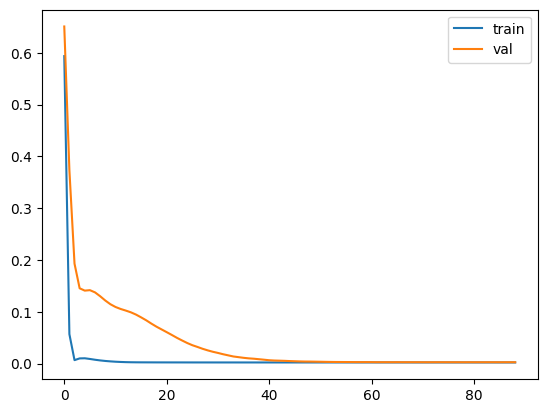

36/36 [==============================] - 0s 2ms/step
AE_MLP After over-sampling Counter({0.0: 626, 1.0: 626})
61/61 [==============================] - 0s 2ms/step

Training on  A549 6mer0mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 3ms/step
model 1DCNN val accu 62.676, auc 0.691
val cm [[93 57]
 [49 85]]
model 1DCNN test accu 58.243, auc 0.594
test cm [[747 419]
 [389 380]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.6091549295774648

model RF val accu 60.915, auc 0.671
val cm [[92 58]
 [53 81]]
model RF test accu 59.535, auc 0.579
test cm [[804 362]
 [421 348]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 2ms/step
model MLP val accu 61.972, auc 0.708
val cm [[84 66]
 [42 92]]
model MLP test accu 55.245, auc 0.588
test cm [[661 505]
 [361 408]]
A549 No.2 fold
class 0 : class 1 = 1.185.
Model: "model"
____________________________________________

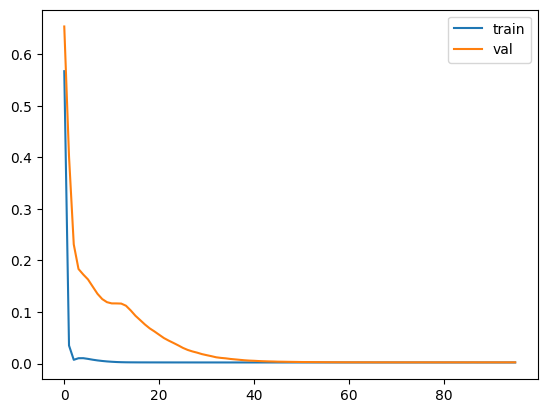

36/36 [==============================] - 0s 3ms/step
AE_MLP After over-sampling Counter({0.0: 616, 1.0: 616})
61/61 [==============================] - 0s 2ms/step

Training on  A549 6mer0mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 3ms/step
model 1DCNN val accu 59.859, auc 0.638
val cm [[112  48]
 [ 66  58]]
model 1DCNN test accu 58.863, auc 0.558
test cm [[851 315]
 [481 288]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.5809859154929577

model RF val accu 58.099, auc 0.615
val cm [[98 62]
 [57 67]]
model RF test accu 59.638, auc 0.586
test cm [[780 386]
 [395 374]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 2ms/step
model MLP val accu 61.972, auc 0.656
val cm [[95 65]
 [43 81]]
model MLP test accu 54.367, auc 0.585
test cm [[626 540]
 [343 426]]
A549 No.3 fold
class 0 : class 1 = 1.210.
Model: "model"
________________________________________

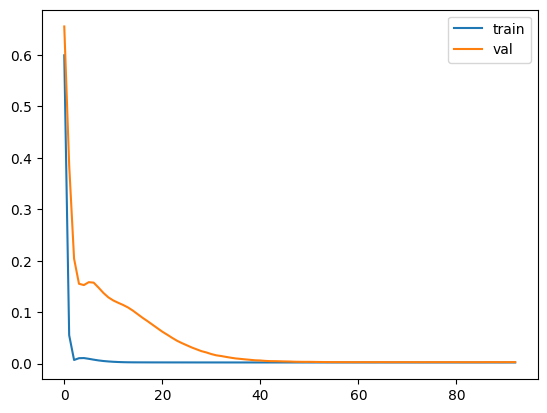

36/36 [==============================] - 0s 3ms/step
AE_MLP After over-sampling Counter({0.0: 622, 1.0: 622})
61/61 [==============================] - 0s 2ms/step

Training on  A549 6mer0mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 2ms/step
model 1DCNN val accu 63.732, auc 0.669
val cm [[105  49]
 [ 54  76]]
model 1DCNN test accu 58.915, auc 0.597
test cm [[759 407]
 [388 381]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.6232394366197183

model RF val accu 62.324, auc 0.675
val cm [[102  52]
 [ 55  75]]
model RF test accu 57.106, auc 0.576
test cm [[760 406]
 [424 345]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 3ms/step
model MLP val accu 61.268, auc 0.660
val cm [[94 60]
 [50 80]]
model MLP test accu 57.674, auc 0.588
test cm [[711 455]
 [364 405]]
A549 No.4 fold
class 0 : class 1 = 1.206.
Model: "model"
____________________________________

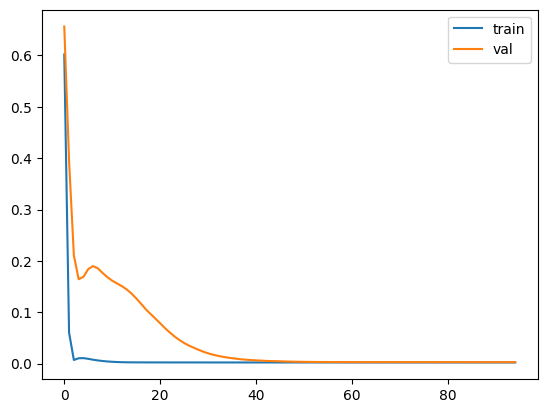

36/36 [==============================] - 0s 2ms/step
AE_MLP After over-sampling Counter({0.0: 621, 1.0: 621})
61/61 [==============================] - 0s 2ms/step

Training on  A549 6mer0mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 2ms/step
model 1DCNN val accu 64.085, auc 0.699
val cm [[104  51]
 [ 51  78]]
model 1DCNN test accu 54.315, auc 0.562
test cm [[659 507]
 [377 392]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.6267605633802817

model RF val accu 62.676, auc 0.675
val cm [[105  50]
 [ 56  73]]
model RF test accu 57.623, auc 0.583
test cm [[737 429]
 [391 378]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 3ms/step
model MLP val accu 67.958, auc 0.702
val cm [[103  52]
 [ 39  90]]
model MLP test accu 51.421, auc 0.562
test cm [[600 566]
 [374 395]]
A549 No.5 fold
class 0 : class 1 = 1.197.
Model: "model"
________________________________

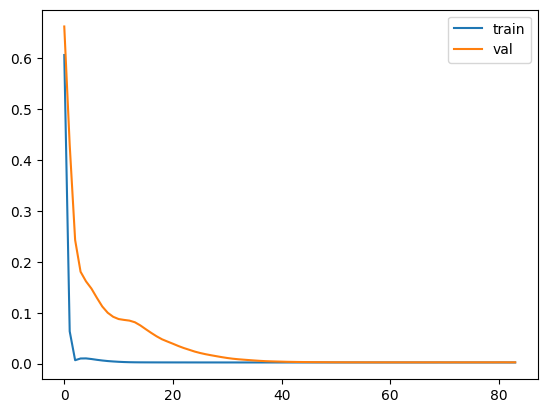

36/36 [==============================] - 0s 5ms/step
AE_MLP After over-sampling Counter({1.0: 619, 0.0: 619})
61/61 [==============================] - 0s 2ms/step

Training on  A549 6mer0mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 1ms/step
model 1DCNN val accu 61.620, auc 0.636
val cm [[108  49]
 [ 60  67]]
model 1DCNN test accu 57.726, auc 0.547
test cm [[815 351]
 [467 302]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.602112676056338

model RF val accu 60.211, auc 0.610
val cm [[93 64]
 [49 78]]
model RF test accu 59.018, auc 0.574
test cm [[768 398]
 [395 374]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 2ms/step
model MLP val accu 59.507, auc 0.650
val cm [[81 76]
 [39 88]]
model MLP test accu 55.762, auc 0.584
test cm [[667 499]
 [357 412]]
A549 No.6 fold
class 0 : class 1 = 1.206.
Model: "model"
_________________________________________

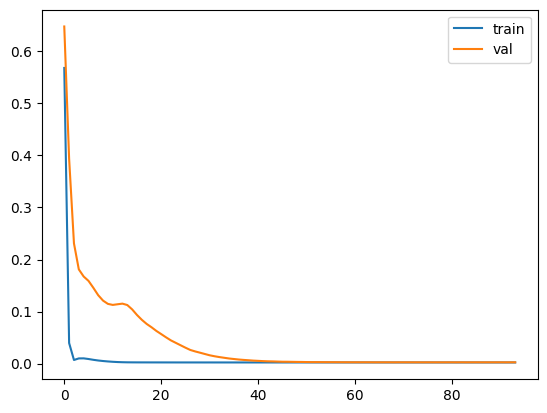

36/36 [==============================] - 0s 2ms/step
AE_MLP After over-sampling Counter({0.0: 621, 1.0: 621})
61/61 [==============================] - 0s 2ms/step

Training on  A549 6mer0mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 2ms/step
model 1DCNN val accu 62.324, auc 0.668
val cm [[113  42]
 [ 65  64]]
model 1DCNN test accu 55.866, auc 0.553
test cm [[778 388]
 [466 303]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.5528169014084507

model RF val accu 55.282, auc 0.593
val cm [[95 60]
 [67 62]]
model RF test accu 57.416, auc 0.587
test cm [[759 407]
 [417 352]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 2ms/step
model MLP val accu 62.324, auc 0.658
val cm [[84 71]
 [36 93]]
model MLP test accu 51.214, auc 0.575
test cm [[516 650]
 [294 475]]
A549 No.7 fold
class 0 : class 1 = 1.214.
Model: "model"
________________________________________

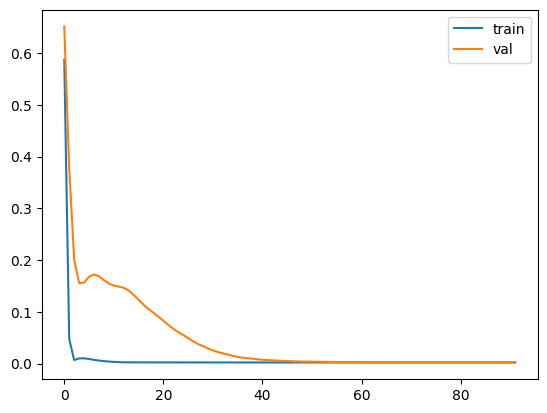

36/36 [==============================] - 0s 3ms/step
AE_MLP After over-sampling Counter({1.0: 623, 0.0: 623})
61/61 [==============================] - 0s 5ms/step

Training on  A549 6mer0mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 4ms/step
model 1DCNN val accu 64.085, auc 0.686
val cm [[96 57]
 [45 86]]
model 1DCNN test accu 56.848, auc 0.574
test cm [[726 440]
 [395 374]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.6056338028169014

model RF val accu 60.563, auc 0.646
val cm [[98 55]
 [57 74]]
model RF test accu 59.276, auc 0.583
test cm [[786 380]
 [408 361]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 3ms/step
model MLP val accu 59.859, auc 0.663
val cm [[88 65]
 [49 82]]
model MLP test accu 55.969, auc 0.583
test cm [[684 482]
 [370 399]]
A549 No.8 fold
class 0 : class 1 = 1.250.
Model: "model"
____________________________________________

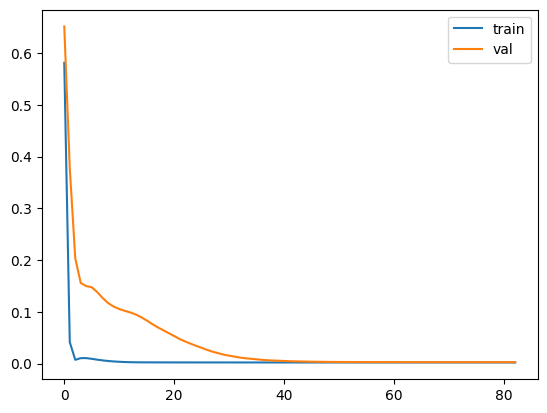

36/36 [==============================] - 0s 2ms/step
AE_MLP After over-sampling Counter({0.0: 631, 1.0: 631})
61/61 [==============================] - 0s 3ms/step

Training on  A549 6mer0mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 5ms/step
model 1DCNN val accu 61.620, auc 0.673
val cm [[103  42]
 [ 67  72]]
model 1DCNN test accu 60.310, auc 0.585
test cm [[856 310]
 [458 311]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.5915492957746479

model RF val accu 59.155, auc 0.661
val cm [[88 57]
 [59 80]]
model RF test accu 59.173, auc 0.588
test cm [[769 397]
 [393 376]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 3ms/step
model MLP val accu 65.493, auc 0.697
val cm [[88 57]
 [41 98]]
model MLP test accu 55.349, auc 0.579
test cm [[658 508]
 [356 413]]
A549 No.9 fold
class 0 : class 1 = 1.168.
Model: "model"
________________________________________

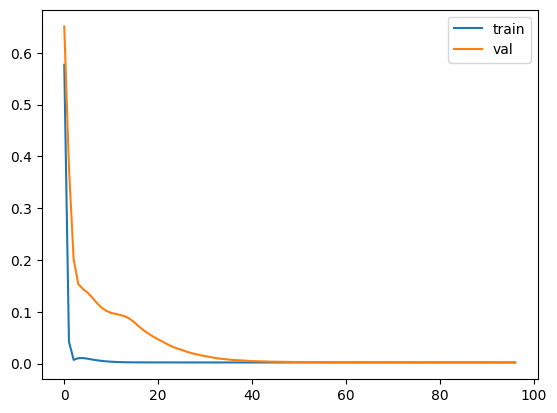

36/36 [==============================] - 0s 2ms/step
AE_MLP After over-sampling Counter({0.0: 612, 1.0: 612})
61/61 [==============================] - 0s 2ms/step

Training on  A549 6mer0mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 2ms/step
model 1DCNN val accu 67.606, auc 0.681
val cm [[135  29]
 [ 63  57]]
model 1DCNN test accu 62.481, auc 0.599
test cm [[983 183]
 [543 226]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.6408450704225352

model RF val accu 64.085, auc 0.678
val cm [[108  56]
 [ 46  74]]
model RF test accu 57.881, auc 0.587
test cm [[765 401]
 [414 355]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 5ms/step
model MLP val accu 61.972, auc 0.686
val cm [[97 67]
 [41 79]]
model MLP test accu 54.264, auc 0.576
test cm [[660 506]
 [379 390]]
A549 No.10 fold
class 0 : class 1 = 1.189.
Model: "model"
___________________________________

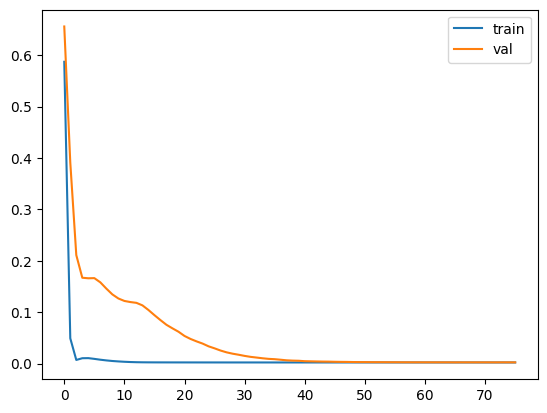

36/36 [==============================] - 0s 3ms/step
AE_MLP After over-sampling Counter({1.0: 617, 0.0: 617})
61/61 [==============================] - 0s 2ms/step

Training on  A549 6mer0mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 5ms/step
model 1DCNN val accu 62.324, auc 0.680
val cm [[97 62]
 [45 80]]
model 1DCNN test accu 52.248, auc 0.556
test cm [[589 577]
 [347 422]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.602112676056338

model RF val accu 60.211, auc 0.670
val cm [[100  59]
 [ 54  71]]
model RF test accu 59.070, auc 0.577
test cm [[785 381]
 [411 358]]

Training on  A549 6mer0mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 1ms/step
model MLP val accu 61.972, auc 0.678
val cm [[100  59]
 [ 49  76]]
model MLP test accu 52.972, auc 0.559
test cm [[626 540]
 [370 399]]
Running time 436.228 seconds

training on A549 6mer1mismatch .
A549 No.1 fold
class 0 : class 

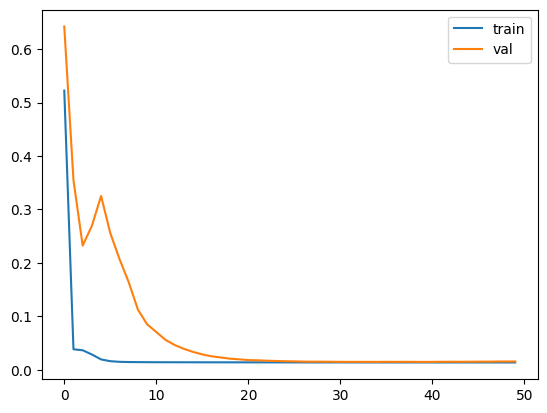

36/36 [==============================] - 0s 2ms/step
AE_MLP After over-sampling Counter({0.0: 626, 1.0: 626})
61/61 [==============================] - 0s 2ms/step

Training on  A549 6mer1mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 2ms/step
model 1DCNN val accu 64.085, auc 0.700
val cm [[101  49]
 [ 53  81]]
model 1DCNN test accu 59.328, auc 0.591
test cm [[841 325]
 [462 307]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.6267605633802817

model RF val accu 62.676, auc 0.651
val cm [[93 57]
 [49 85]]
model RF test accu 55.297, auc 0.582
test cm [[667 499]
 [366 403]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 4ms/step
model MLP val accu 63.732, auc 0.700
val cm [[85 65]
 [38 96]]
model MLP test accu 56.744, auc 0.589
test cm [[710 456]
 [381 388]]
A549 No.2 fold
class 0 : class 1 = 1.185.
Model: "model"
________________________________________

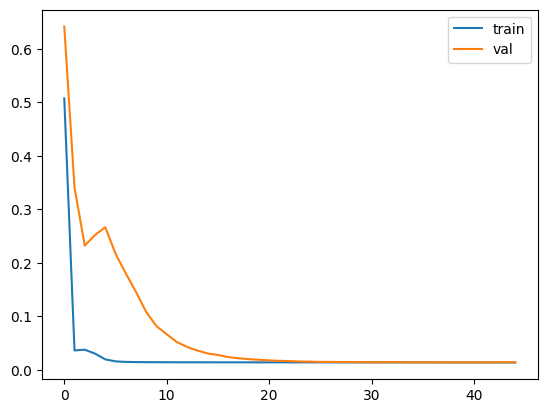

36/36 [==============================] - 0s 3ms/step
AE_MLP After over-sampling Counter({0.0: 616, 1.0: 616})
61/61 [==============================] - 0s 1ms/step

Training on  A549 6mer1mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 5ms/step
model 1DCNN val accu 59.507, auc 0.632
val cm [[108  52]
 [ 63  61]]
model 1DCNN test accu 54.212, auc 0.531
test cm [[727 439]
 [447 322]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.5633802816901409

model RF val accu 56.338, auc 0.624
val cm [[97 63]
 [61 63]]
model RF test accu 57.984, auc 0.565
test cm [[775 391]
 [422 347]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 4ms/step
model MLP val accu 61.620, auc 0.637
val cm [[110  50]
 [ 59  65]]
model MLP test accu 58.398, auc 0.545
test cm [[857 309]
 [496 273]]
A549 No.3 fold
class 0 : class 1 = 1.210.
Model: "model"
____________________________________

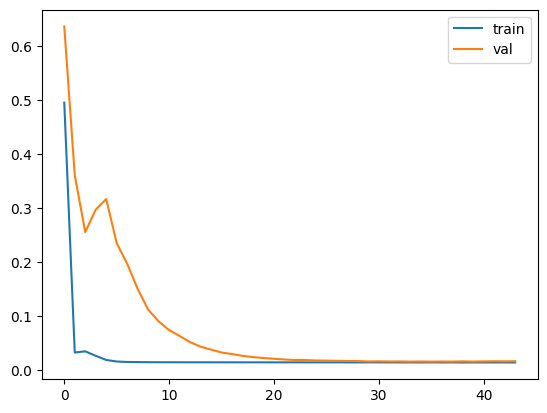

36/36 [==============================] - 0s 2ms/step
AE_MLP After over-sampling Counter({0.0: 622, 1.0: 622})
61/61 [==============================] - 0s 4ms/step

Training on  A549 6mer1mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 4ms/step
model 1DCNN val accu 65.845, auc 0.689
val cm [[113  41]
 [ 56  74]]
model 1DCNN test accu 57.726, auc 0.563
test cm [[784 382]
 [436 333]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.6549295774647887

model RF val accu 65.493, auc 0.683
val cm [[104  50]
 [ 48  82]]
model RF test accu 55.607, auc 0.551
test cm [[703 463]
 [396 373]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 4ms/step
model MLP val accu 63.380, auc 0.668
val cm [[92 62]
 [42 88]]
model MLP test accu 55.659, auc 0.566
test cm [[676 490]
 [368 401]]
A549 No.4 fold
class 0 : class 1 = 1.206.
Model: "model"
____________________________________

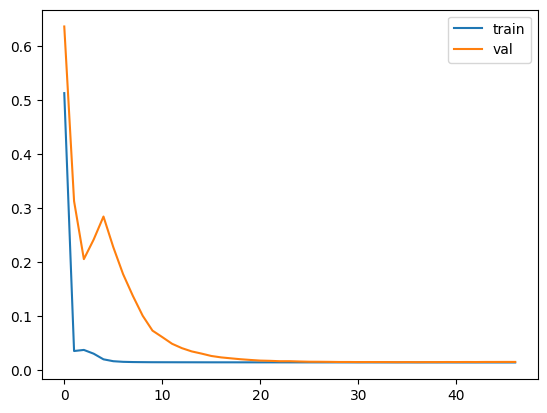

36/36 [==============================] - 0s 3ms/step
AE_MLP After over-sampling Counter({0.0: 621, 1.0: 621})
61/61 [==============================] - 0s 2ms/step

Training on  A549 6mer1mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 6ms/step
model 1DCNN val accu 65.493, auc 0.700
val cm [[103  52]
 [ 46  83]]
model 1DCNN test accu 56.899, auc 0.571
test cm [[735 431]
 [403 366]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.6373239436619719

model RF val accu 63.732, auc 0.689
val cm [[109  46]
 [ 57  72]]
model RF test accu 56.899, auc 0.570
test cm [[751 415]
 [419 350]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 3ms/step
model MLP val accu 65.141, auc 0.700
val cm [[90 65]
 [34 95]]
model MLP test accu 54.574, auc 0.560
test cm [[633 533]
 [346 423]]
A549 No.5 fold
class 0 : class 1 = 1.197.
Model: "model"
____________________________________

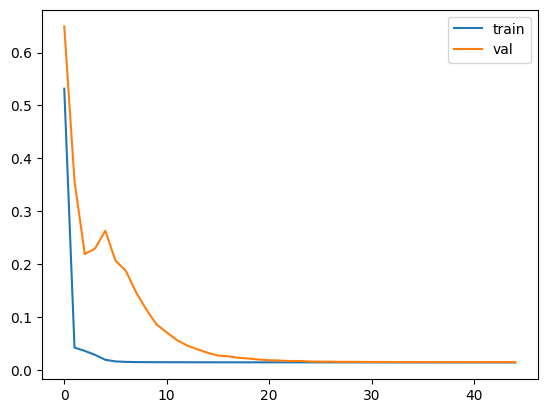

36/36 [==============================] - 0s 5ms/step
AE_MLP After over-sampling Counter({1.0: 619, 0.0: 619})
61/61 [==============================] - 0s 2ms/step

Training on  A549 6mer1mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 5ms/step
model 1DCNN val accu 61.972, auc 0.651
val cm [[109  48]
 [ 60  67]]
model 1DCNN test accu 59.638, auc 0.581
test cm [[820 346]
 [435 334]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.5950704225352113

model RF val accu 59.507, auc 0.637
val cm [[99 58]
 [57 70]]
model RF test accu 55.245, auc 0.582
test cm [[652 514]
 [352 417]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 4ms/step
model MLP val accu 59.507, auc 0.629
val cm [[83 74]
 [41 86]]
model MLP test accu 54.574, auc 0.578
test cm [[623 543]
 [336 433]]
A549 No.6 fold
class 0 : class 1 = 1.206.
Model: "model"
________________________________________

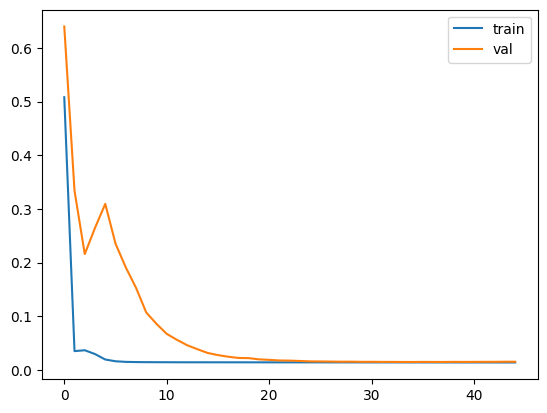

36/36 [==============================] - 0s 2ms/step
AE_MLP After over-sampling Counter({0.0: 621, 1.0: 621})
61/61 [==============================] - 0s 4ms/step

Training on  A549 6mer1mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 1ms/step
model 1DCNN val accu 65.141, auc 0.682
val cm [[119  36]
 [ 63  66]]
model 1DCNN test accu 60.827, auc 0.580
test cm [[885 281]
 [477 292]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.5880281690140845

model RF val accu 58.803, auc 0.642
val cm [[97 58]
 [59 70]]
model RF test accu 57.106, auc 0.572
test cm [[727 439]
 [391 378]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 1ms/step
model MLP val accu 65.845, auc 0.674
val cm [[115  40]
 [ 57  72]]
model MLP test accu 58.295, auc 0.564
test cm [[831 335]
 [472 297]]
A549 No.7 fold
class 0 : class 1 = 1.214.
Model: "model"
____________________________________

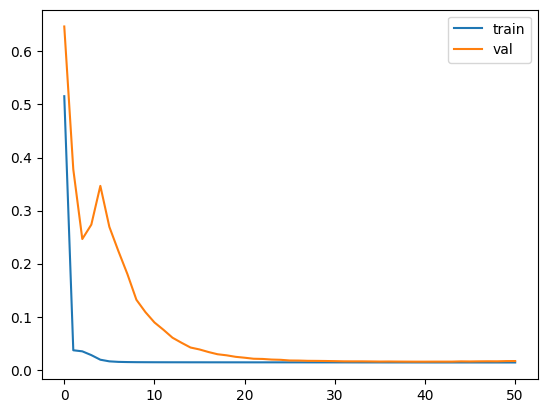

36/36 [==============================] - 0s 4ms/step
AE_MLP After over-sampling Counter({1.0: 623, 0.0: 623})
61/61 [==============================] - 0s 2ms/step

Training on  A549 6mer1mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 1ms/step
model 1DCNN val accu 61.268, auc 0.644
val cm [[102  51]
 [ 59  72]]
model 1DCNN test accu 58.708, auc 0.560
test cm [[845 321]
 [478 291]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.5950704225352113

model RF val accu 59.507, auc 0.621
val cm [[90 63]
 [52 79]]
model RF test accu 51.990, auc 0.533
test cm [[631 535]
 [394 375]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 1ms/step
model MLP val accu 62.324, auc 0.628
val cm [[99 54]
 [53 78]]
model MLP test accu 58.450, auc 0.566
test cm [[823 343]
 [461 308]]
A549 No.8 fold
class 0 : class 1 = 1.250.
Model: "model"
________________________________________

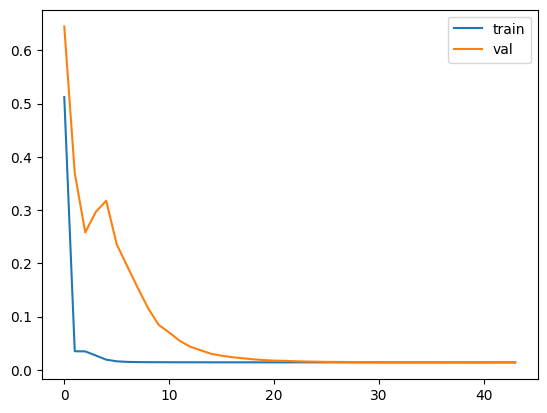

36/36 [==============================] - 0s 3ms/step
AE_MLP After over-sampling Counter({1.0: 631, 0.0: 631})
61/61 [==============================] - 0s 2ms/step

Training on  A549 6mer1mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 5ms/step
model 1DCNN val accu 62.676, auc 0.702
val cm [[ 76  69]
 [ 37 102]]
model 1DCNN test accu 54.367, auc 0.574
test cm [[622 544]
 [339 430]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.6373239436619719

model RF val accu 63.732, auc 0.685
val cm [[101  44]
 [ 59  80]]
model RF test accu 55.969, auc 0.560
test cm [[743 423]
 [429 340]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 1ms/step
model MLP val accu 61.972, auc 0.682
val cm [[80 65]
 [43 96]]
model MLP test accu 55.814, auc 0.563
test cm [[689 477]
 [378 391]]
A549 No.9 fold
class 0 : class 1 = 1.168.
Model: "model"
____________________________________

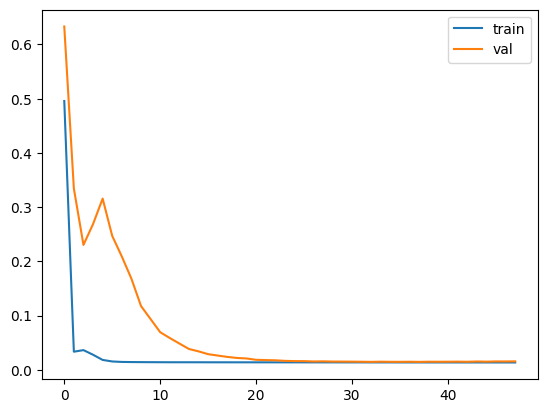

36/36 [==============================] - 0s 4ms/step
AE_MLP After over-sampling Counter({1.0: 612, 0.0: 612})
61/61 [==============================] - 0s 2ms/step

Training on  A549 6mer1mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 3ms/step
model 1DCNN val accu 63.732, auc 0.660
val cm [[106  58]
 [ 45  75]]
model 1DCNN test accu 56.589, auc 0.573
test cm [[750 416]
 [424 345]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.6302816901408451

model RF val accu 63.028, auc 0.680
val cm [[104  60]
 [ 45  75]]
model RF test accu 56.486, auc 0.575
test cm [[696 470]
 [372 397]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 4ms/step
model MLP val accu 60.563, auc 0.643
val cm [[103  61]
 [ 51  69]]
model MLP test accu 55.659, auc 0.554
test cm [[745 421]
 [437 332]]
A549 No.10 fold
class 0 : class 1 = 1.189.
Model: "model"
_______________________________

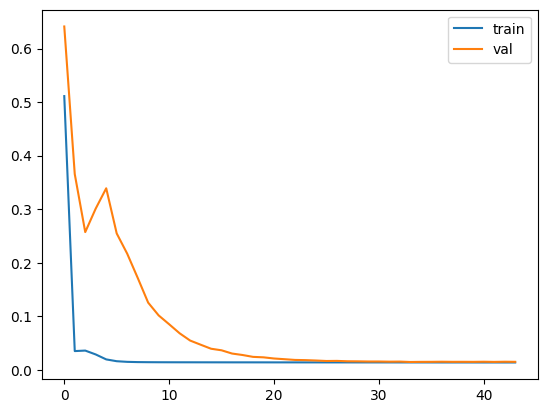

36/36 [==============================] - 0s 1ms/step
AE_MLP After over-sampling Counter({0.0: 617, 1.0: 617})
61/61 [==============================] - 0s 3ms/step

Training on  A549 6mer1mismatch AE_MLP,rawcounts 1DCNN 200 5000. 

61/61 [==============================] - 0s 2ms/step
model 1DCNN val accu 61.268, auc 0.655
val cm [[105  54]
 [ 56  69]]
model 1DCNN test accu 58.605, auc 0.559
test cm [[796 370]
 [431 338]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts RF 200 5000. 

RF accuracy: 0.6197183098591549

model RF val accu 61.972, auc 0.667
val cm [[96 63]
 [45 80]]
model RF test accu 53.333, auc 0.566
test cm [[614 552]
 [351 418]]

Training on  A549 6mer1mismatch AE_MLP,rawcounts MLP 200 5000. 

61/61 [==============================] - 0s 2ms/step
model MLP val accu 60.211, auc 0.639
val cm [[95 64]
 [49 76]]
model MLP test accu 54.264, auc 0.540
test cm [[684 482]
 [403 366]]
Running time 414.909 seconds


In [7]:
for Q in range(0,max_miss+1):
    _train = pd.read_csv(path_input+encoding+"_noncoding_train_%smer%smiss.csv"%(K,Q),index_col=0)
    data_train = _train.iloc[:,0:-18].div(_train["length"],axis=0)
    data_train[["transcript_id","gene_id","length"]] = _train[["transcript_id","gene_id","length"]]

    _test = pd.read_csv(path_input+encoding+"_noncoding_test_%smer%smiss.csv"%(K,Q),index_col=0)
    data_test = _test.iloc[:,0:-18].div(_test["length"],axis=0)
    data_test[["transcript_id","gene_id","length"]] = _test[["transcript_id","gene_id","length"]]

#     _apex = pd.read_csv(apex_seq+encoding+"_coding_apex_%smer%smiss_200-5000_longest.csv"%(K,Q),index_col=0)
#     data_apex = _apex.iloc[:,0:-6].div(_apex["length"],axis=0)
#     data_apex[["transcript_id","gene_id","length","Class"]] =  _apex[["transcript_id","gene_id","length","Class"]]


    for Celline in _celline:
        _df_train = data_train.copy()
        _df_train[Celline] = _train[Celline]
        _df_train = _df_train.dropna(axis=0).reset_index(drop=True)
        _df_train = get_class(_df_train)

        _df_test = data_test.copy()
        _df_test[Celline] = _test[Celline]
        _df_test = _df_test.dropna(axis=0).reset_index(drop=True)
        _df_test = get_class(_df_test)
#         _df_apex = data_apex.copy()
#         _df_apex["Class"] = _apex["Class"]
#         _df_apex = _df_apex.dropna(axis=0).reset_index(drop=True)

        genes = pd.DataFrame(_df_train.gene_id.unique(),columns=["gene_id"])

        print()
        print("training on %s %smer%smismatch ."%(Celline,K,Q ))

        train()

In [8]:
_celline = ["A549"]
for model_type in _model_type:
    for (m,n) in segment:
        for Celline in _celline:
            for Q in range(0,max_miss+1):
                for ae in ae_type:
                    eva_val0_file = path_output + "10fold_%s_%s_training_length_%s_%s_%s_%s_%s_%smer%smiss_val0.xlsx"%(Celline,ae,m,n,encoding,threshold,model_type,K,Q)
                    eva_test0_file = path_output + "10fold_%s_%s_training_length_%s_%s_%s_%s_%s_%smer%smiss_test0.xlsx"%(Celline,ae,m,n,encoding,threshold,model_type,K,Q)
#                     eva_test_apex_file = path_apex + "10fold_%s_%s_training_length_%s_%s_%s_%s_%s_%smer%smiss_test_apex.xlsx"%(Celline,ae,m,n,encoding,threshold,model_type,K,Q)
                    for infile in [eva_val0_file,eva_test0_file]:
                        print(infile)
                        writer = ExcelWriter(infile, engine='openpyxl',mode='a')
                        xl = pd.ExcelFile(infile)
                        eva = []

                        for i in range(1,11):
                            eva.append(xl.parse('eva'+str(i),index_col=0))

                        df_eva_avg =  pd.concat(eva).groupby(level=0).mean()

                        df_eva_avg.to_excel(writer,sheet_name='eva_avg')

                        writer.close()

../results/with_ae/SMOTE/mer6_20250519/10fold_A549_AE_MLP_training_length_200_5000_rawcounts_class_0_1DCNN_6mer0miss_val0.xlsx
../results/with_ae/SMOTE/mer6_20250519/10fold_A549_AE_MLP_training_length_200_5000_rawcounts_class_0_1DCNN_6mer0miss_test0.xlsx
../results/with_ae/SMOTE/mer6_20250519/10fold_A549_AE_MLP_training_length_200_5000_rawcounts_class_0_1DCNN_6mer1miss_val0.xlsx
../results/with_ae/SMOTE/mer6_20250519/10fold_A549_AE_MLP_training_length_200_5000_rawcounts_class_0_1DCNN_6mer1miss_test0.xlsx
../results/with_ae/SMOTE/mer6_20250519/10fold_A549_AE_MLP_training_length_200_5000_rawcounts_class_0_RF_6mer0miss_val0.xlsx
../results/with_ae/SMOTE/mer6_20250519/10fold_A549_AE_MLP_training_length_200_5000_rawcounts_class_0_RF_6mer0miss_test0.xlsx
../results/with_ae/SMOTE/mer6_20250519/10fold_A549_AE_MLP_training_length_200_5000_rawcounts_class_0_RF_6mer1miss_val0.xlsx
../results/with_ae/SMOTE/mer6_20250519/10fold_A549_AE_MLP_training_length_200_5000_rawcounts_class_0_RF_6mer1miss_tes

In [9]:
current_time = datetime.datetime.now(pytz.timezone('America/New_York'))
# printing current time in india
print("The current time is :", current_time)

The current time is : 2025-05-19 14:02:36.803742-04:00
